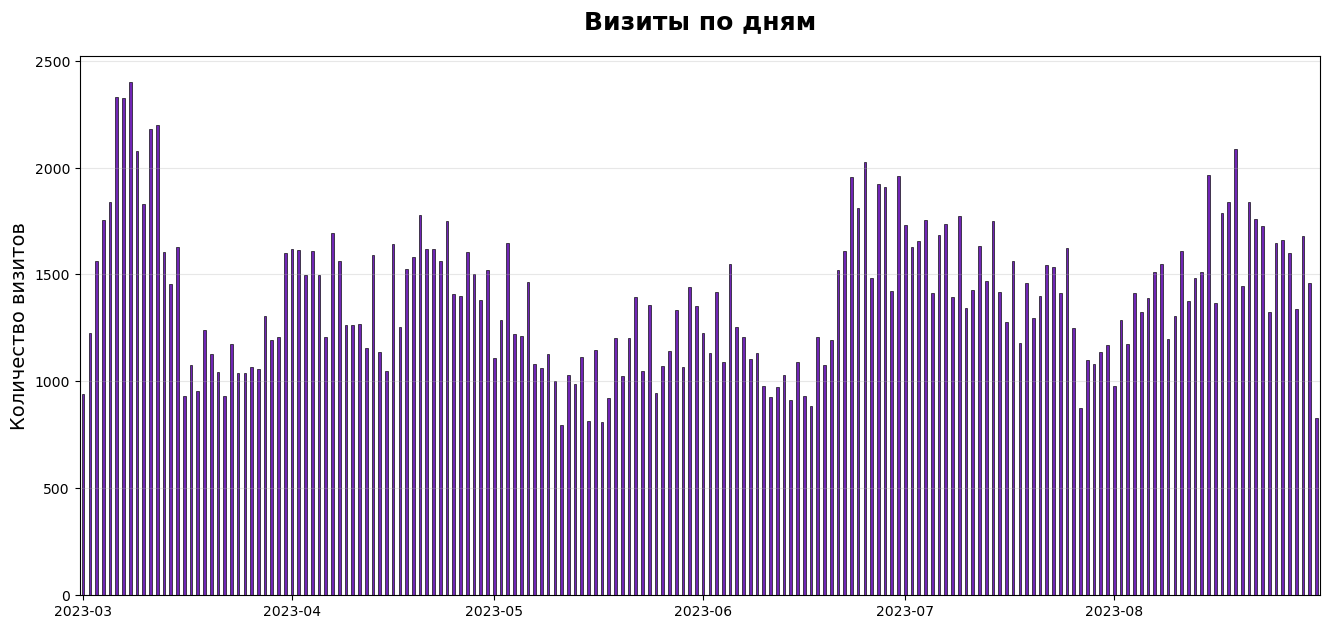

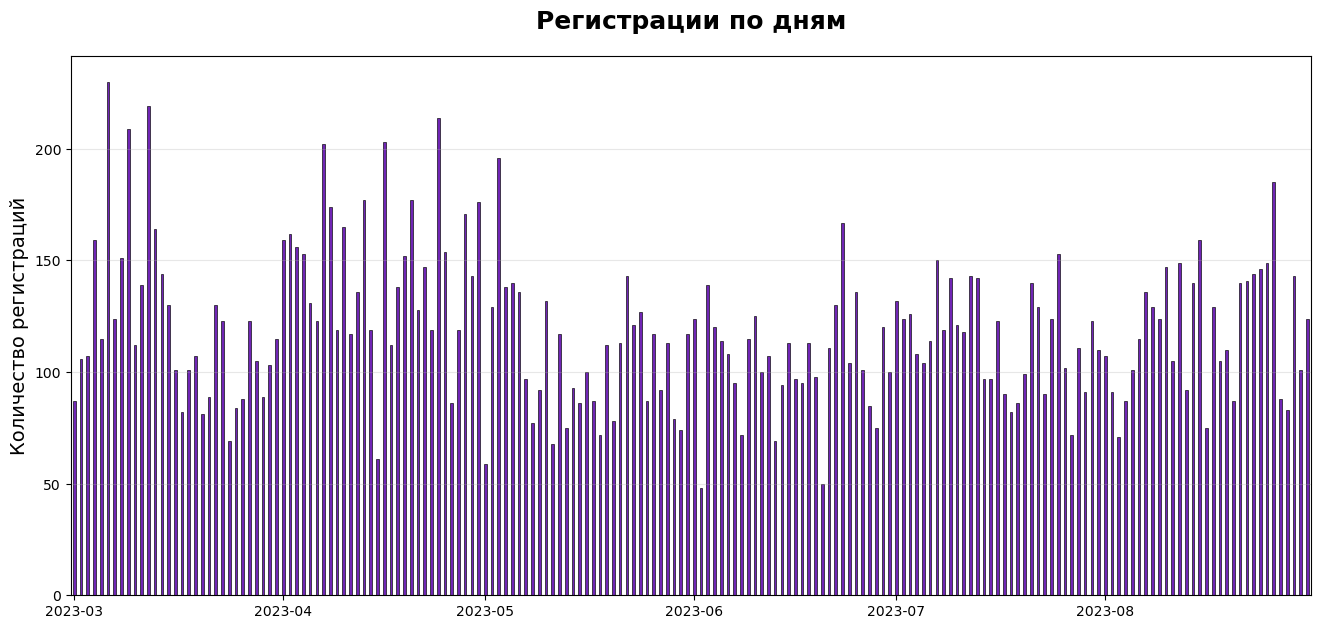

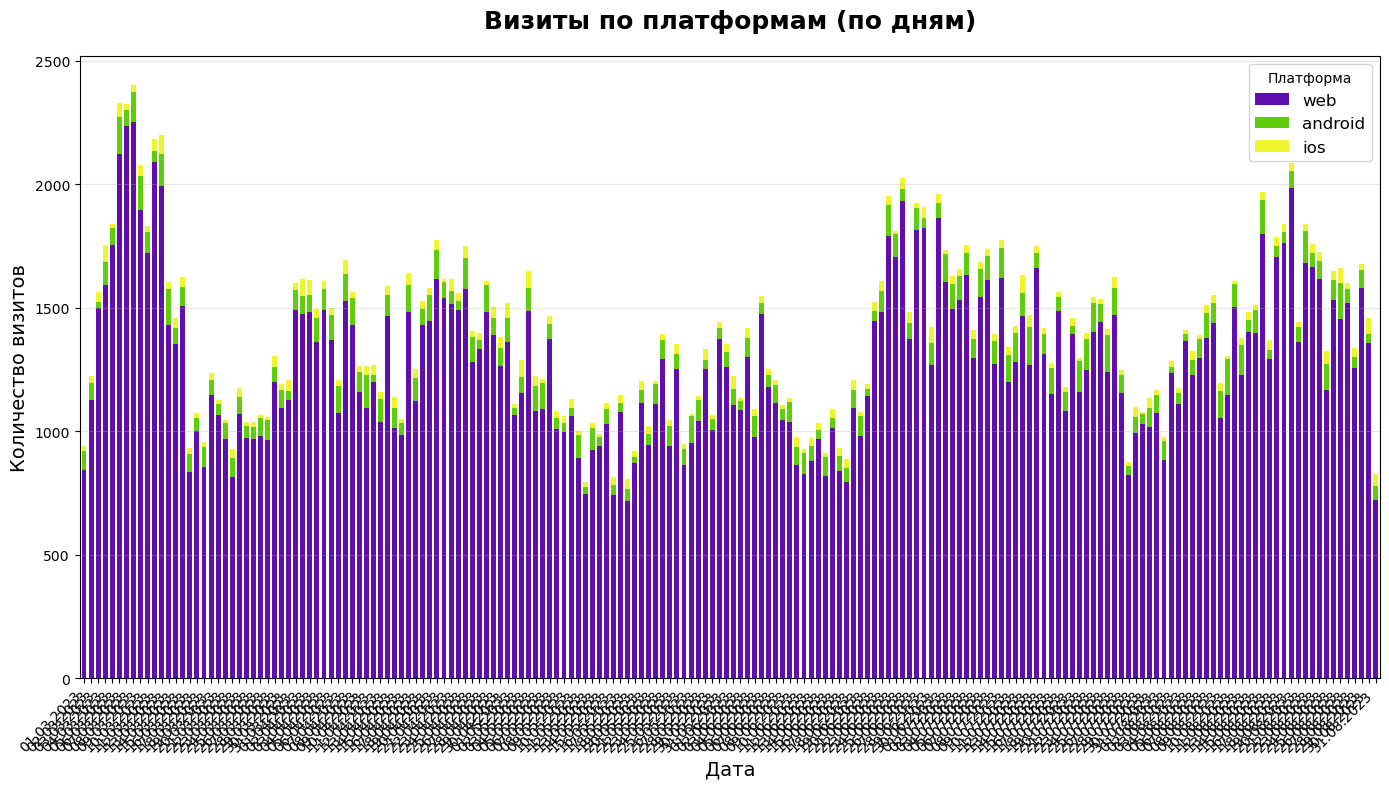

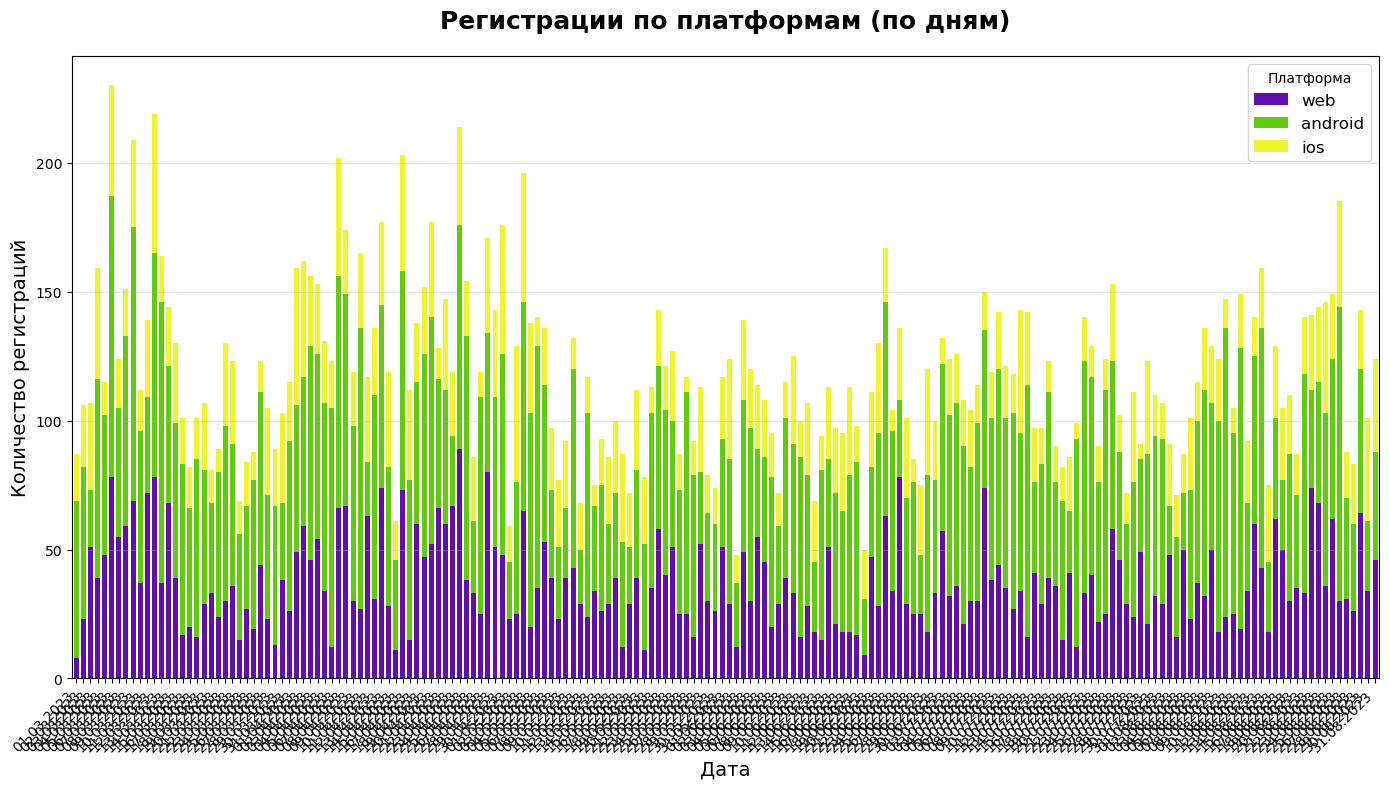

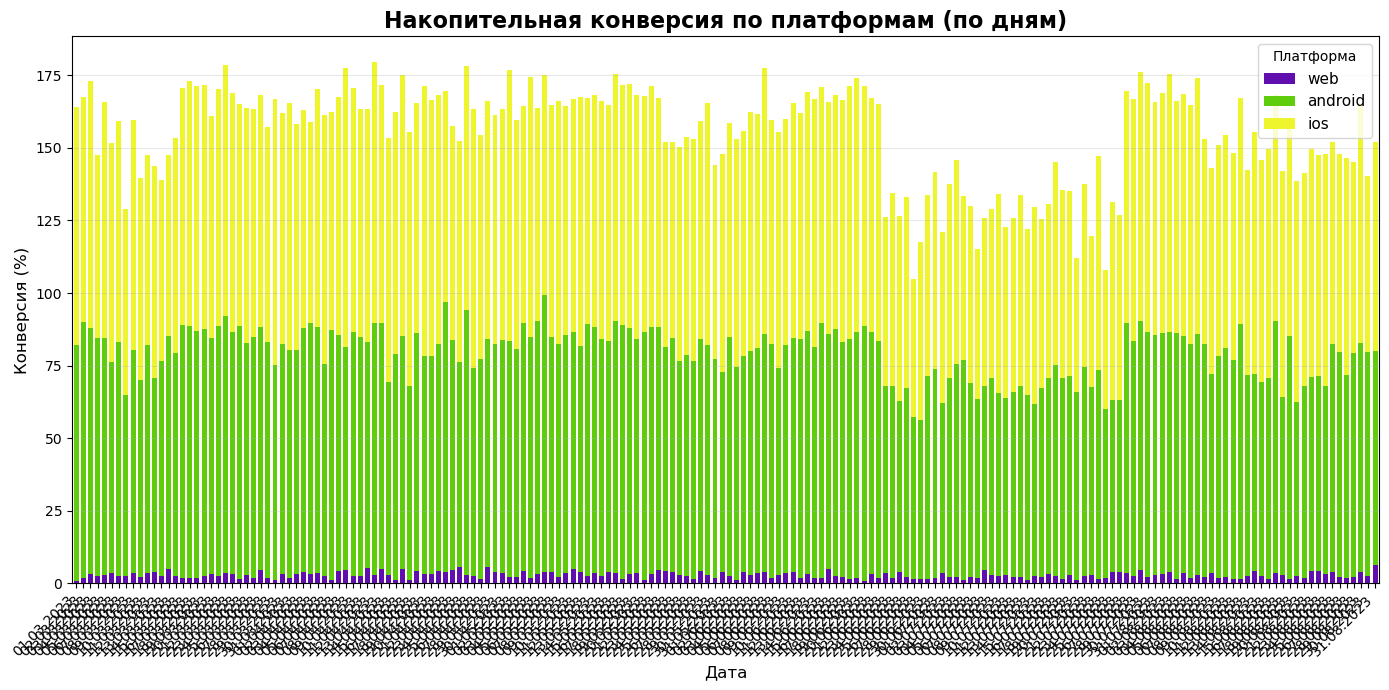

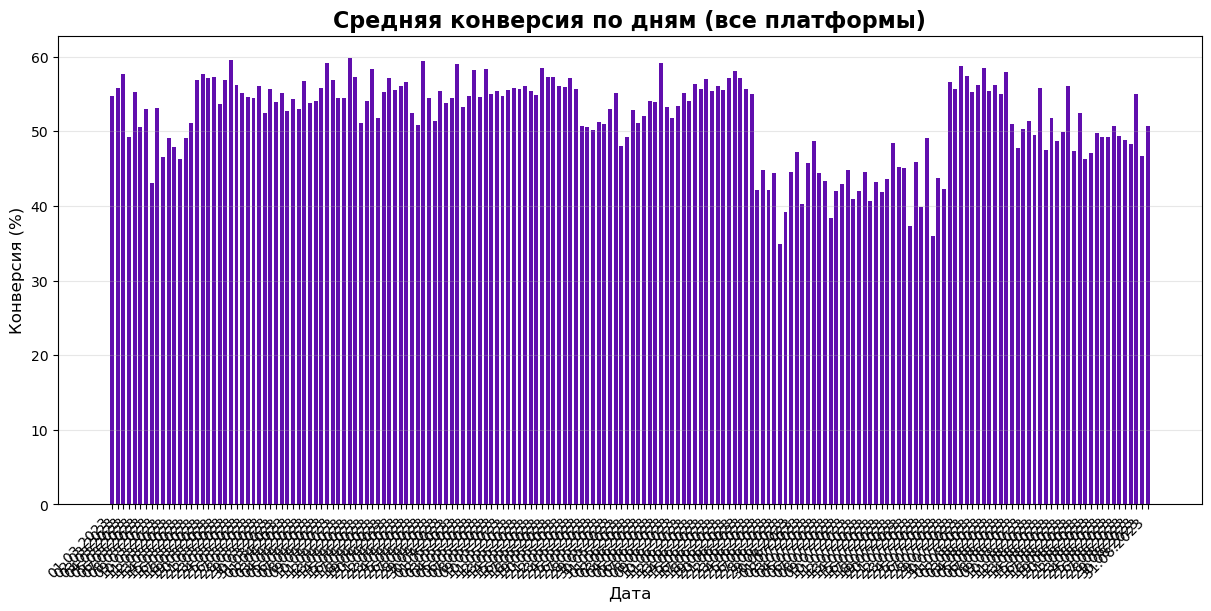

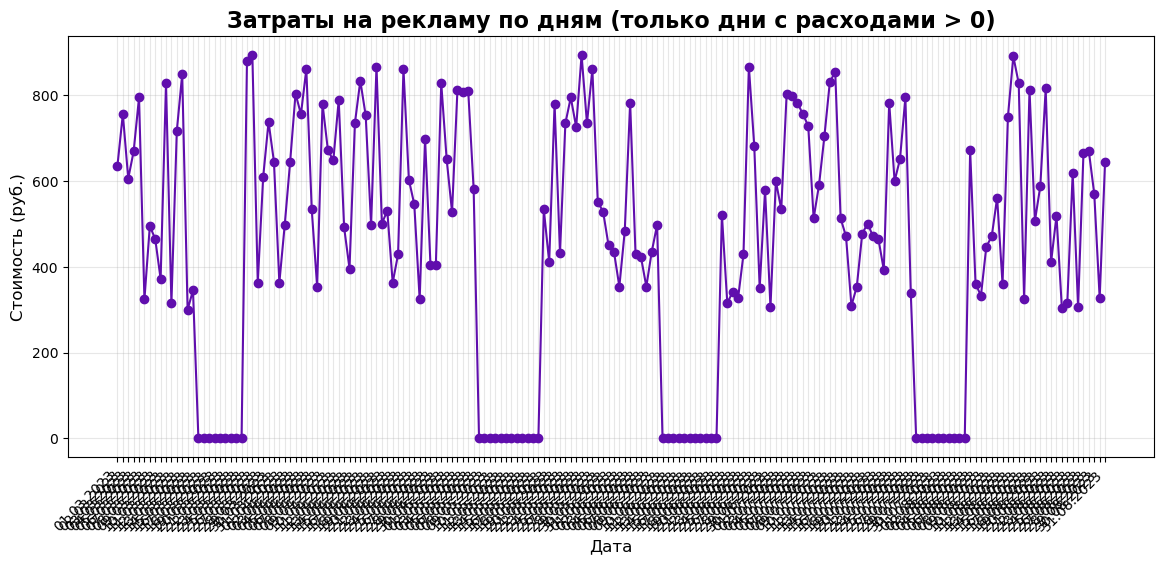

In [6]:
from dotenv import load_dotenv
import os
import requests
import pandas as pd
from datetime import datetime
import json
import matplotlib.pyplot as plt

#обращение к файлу с исходными данными
load_dotenv('.env')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

reg = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
vis = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})

#обработка регистраций
df_reg = pd.DataFrame(reg.json())
df_vis = pd.DataFrame(vis.json())
df_reg['datetime'] = pd.to_datetime(df_reg['datetime'])
df_reg['datetime'] = df_reg['datetime'].dt.normalize()
df_reg.sort_values(by=['user_id', 'datetime'], ascending=[True, True], inplace=True)
df_reg_last = df_reg.drop_duplicates(subset='user_id', keep='last').copy()
df_reg_filtered = df_reg_last[~df_reg_last['platform'].str.contains('bot', na=False)]
reg_summary = df_reg_filtered.groupby(['datetime', 'platform']).size().reset_index(name='registrations')
reg_summary = reg_summary.rename(columns={'datetime': 'date_group'})
reg_summary['date_group'] = reg_summary['date_group'].apply(
    lambda ts: int(ts.timestamp())
)


#обработка визитов
df_vis['datetime'] = pd.to_datetime(df_vis['datetime'])
df_vis['date'] = df_vis['datetime'].dt.date
df_vis_filtered = df_vis[df_vis['platform'] != 'bot']
vis_summary = df_vis_filtered.groupby(['date', 'platform']).size().reset_index(name='visits')
vis_summary = vis_summary.rename(columns={'date': 'date_group'})
vis_summary['date_group'] = pd.to_datetime(vis_summary['date_group']).apply(
    lambda x: int(x.timestamp())
)

#объединение файлов, корректировка данных, расчет конверсий
result = pd.merge(
    vis_summary,
    reg_summary,
    on=['date_group', 'platform'],
    how='left'
    )
result = result.fillna(0)
result['registrations'] = result['registrations'].astype(int)
result['visits'] = result['visits'].astype(int)
result['conversion'] = (result['registrations'] / result['visits']) * 100
result['conversion'] = result['conversion'].fillna(0).round(3)

#сохранение в файл conversion.json
result.to_json('conversion.json', orient='records', 
                  force_ascii=False,
                  date_format='epoch')
    

#обработка файла с данными рекламы
ADS_CSV_PATH = 'ads.csv'
df_ads = pd.read_csv(ADS_CSV_PATH)
df_ads = df_ads.rename(columns={'date': 'date_group'})
df_ads['date_group'] = pd.to_datetime(df_ads['date_group'])         
df_ads['date_group'] = df_ads['date_group'].dt.normalize()
df_ads['date_group'] = pd.to_datetime(df_ads['date_group']).apply(lambda x: int(x.timestamp()))
ads_summary = df_ads.groupby(['date_group', 'utm_source', 'utm_campaign'])['cost'].sum().reset_index()

#соединение предыдущего вывода с данными из файла
result = pd.merge(
    result,
    ads_summary,
    on='date_group',
    how='left'
)
result['cost'] = result['cost'].fillna(0)
result = result[['date_group', 'platform', 'visits', 'registrations', 'conversion', 'utm_source', 'utm_campaign', 'cost']]
result = result.sort_values(['date_group', 'platform']).reset_index(drop=True)

#сохранение в файл
result.to_json('ads.json', orient='records', 
                  force_ascii=False,  # аналог ensure_ascii=False
                  date_format='epoch')

#создание папки для графиков
os.makedirs('charts', exist_ok=True)

# Визиты по дням
result['date_readable'] = pd.to_datetime(result['date_group'], unit='s')
visits_by_day = result.groupby('date_readable')['visits'].sum().reset_index()
visits_by_day['date_label'] = visits_by_day['date_readable'].dt.strftime('%d.%m.%Y')
visits_by_day['date_plot'] = visits_by_day['date_readable']
plt.figure(figsize=(16, 7))
bars = plt.bar(
    visits_by_day['date_plot'],
    visits_by_day['visits'],
    width=0.4,                
    alpha=0.9,
    color='#600ead',           
    edgecolor='black',
    linewidth=0.5
)
plt.title('Визиты по дням', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Количество визитов', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xlim(
    visits_by_day['date_plot'].min() - pd.Timedelta(days=0.5),
    visits_by_day['date_plot'].max() + pd.Timedelta(days=0.5)
)
plt.savefig(os.path.join('charts/final_visits.png'), dpi=300, bbox_inches='tight')

# Регистраций по дням
result['date_readable'] = pd.to_datetime(result['date_group'], unit='s')
reg_by_day = result.groupby('date_readable')['registrations'].sum().reset_index()
reg_by_day['date_label'] = visits_by_day['date_readable'].dt.strftime('%d.%m.%Y')
reg_by_day['date_plot'] = visits_by_day['date_readable']
plt.figure(figsize=(16, 7))
bars = plt.bar(
    reg_by_day['date_plot'],
    reg_by_day['registrations'],
    width=0.4,                
    alpha=0.9,
    color='#600ead',           
    edgecolor='black',
    linewidth=0.5
)
plt.title('Регистрации по дням', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Количество регистраций', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xlim(
    visits_by_day['date_plot'].min() - pd.Timedelta(days=0.5),
    visits_by_day['date_plot'].max() + pd.Timedelta(days=0.5)
)

plt.savefig(os.path.join('charts/final_reg.png'), dpi=300, bbox_inches='tight')

# визиты по платформам

result['date_readable'] = pd.to_datetime(result['date_group'], unit='s')

platforms = ['web', 'android', 'ios']
filtered_result = result[result['platform'].isin(platforms)]
visits_by_day_platform = (
    filtered_result
    .groupby(['date_readable', 'platform'])['visits']
    .sum()
    .unstack(fill_value=0)  
    [platforms]
)
plt.figure(figsize=(14, 8))
colors = ['#600ead', '#5fcc0c', '#eef52c']  # web, android, ios
bars = visits_by_day_platform.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=plt.gca(),
    width=0.7
)
plt.title('Визиты по платформам (по дням)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество визитов', fontsize=14)
plt.legend(title='Платформа', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(
    ticks=range(len(visits_by_day_platform.index)),
    labels=[d.strftime('%d.%m.%Y') for d in visits_by_day_platform.index],
    rotation=45,
    ha='right'
)
plt.tight_layout()
output_dir = 'charts'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(
    os.path.join('charts/visits_platform.png'),
    dpi=300,
    bbox_inches='tight'
)

# регистрации по платформам
result['date_readable'] = pd.to_datetime(result['date_group'], unit='s')
platforms = ['web', 'android', 'ios']
filtered_result = result[result['platform'].isin(platforms)]
reg_by_day_platform = (
    filtered_result
    .groupby(['date_readable', 'platform'])['registrations']
    .sum()
    .unstack(fill_value=0)  
    [platforms]
)
plt.figure(figsize=(14, 8))
colors = ['#600ead', '#5fcc0c', '#eef52c']  # web, android, ios
bars = reg_by_day_platform.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=plt.gca(),
    width=0.7
)
plt.title('Регистрации по платформам (по дням)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество регистраций', fontsize=14)
plt.legend(title='Платформа', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(
    ticks=range(len(reg_by_day_platform.index)),
    labels=[d.strftime('%d.%m.%Y') for d in reg_by_day_platform.index],
    rotation=45,
    ha='right'
)
plt.tight_layout()
output_dir = 'charts'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(
    os.path.join('charts/reg_platform.png'),
    dpi=300,
    bbox_inches='tight'
)

# накопительная конверсия по платформам
result['date_readable'] = pd.to_datetime(result['date_group'], unit='s').dt.date
platforms = ['web', 'android', 'ios']
filtered_result = result[result['platform'].isin(platforms)]
daily_conversion_by_platform = (
    filtered_result
    .groupby(['date_readable', 'platform'])['conversion']
    .mean() 
    .unstack(fill_value=0)
    [platforms]  
)
plt.figure(figsize=(14, 7))
colors = ['#600ead', '#5fcc0c', '#eef52c']  # web, android, ios
bars = daily_conversion_by_platform.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=plt.gca(),
    width=0.7
)
plt.title('Накопительная конверсия по платформам (по дням)', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)

plt.legend(title='Платформа', fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.xticks(
    ticks=range(len(daily_conversion_by_platform.index)),
    labels=[d.strftime('%d.%m.%Y') for d in daily_conversion_by_platform.index],
    rotation=45,
    ha='right'
)
plt.tight_layout()
output_dir = 'charts'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(
    os.path.join('charts/conversion_platform.png'),
    dpi=300,
    bbox_inches='tight'
)

#средняя конверсия
result['date_readable'] = pd.to_datetime(result['date_group'], unit='s').dt.date
result['cr_daily'] = result['registrations'] / result['visits']
daily_avg_conversion = (
    result
    .groupby('date_readable')['cr_daily']
    .mean()
    .round(10)
) * 100

plt.figure(figsize=(12, 6), constrained_layout=True)
bars = plt.bar(
    daily_avg_conversion.index,
    daily_avg_conversion.values,
    color='#600ead',
    width=0.7
)
plt.title('Средняя конверсия по дням (все платформы)', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(
    ticks=daily_avg_conversion.index,
    labels=[d.strftime('%d.%m.%Y') for d in daily_avg_conversion.index],
    rotation=45,
    ha='right'
)
output_dir = 'charts'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(
    os.path.join('charts/avg_conversion_all_platforms.png'),
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.05
)

#затраты
daily_cost = result.groupby('date_readable')['cost'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(
    daily_cost['date_readable'],
    daily_cost['cost'],
    marker='o',
    linewidth=1.5,
    color='#600ead',
    markersize=6
)
plt.title('Затраты на рекламу по дням (только дни с расходами > 0)', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Стоимость (руб.)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(
    ticks=daily_cost['date_readable'],
    labels=[d.strftime('%d.%m.%Y') for d in daily_cost['date_readable']],
    rotation=45,
    ha='right',
    fontsize=10
)
plt.tight_layout(pad=2.0)
output_dir = 'charts'
os.makedirs(output_dir, exist_ok=True)

plt.savefig(
    os.path.join('charts/total_cost.png'),
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
)